## Filtering

Materials are based on [Neural Signal Processing (UCSD COGS118C)](https://github.com/rdgao/COGS118C) by Richard Gao (see the [LICENSE](https://github.com/rdgao/COGS118C/blob/master/LICENSE)).

In [ ]:
# make the imports
import numpy as np
from scipy import io, signal
import bokeh, bokeh.io, bokeh.plotting # for fancy plots
bokeh.io.output_notebook()

### Load some real brain signals
We'll be working with the LFP data recorded in the rat hippocampus. This dataset comes from an openly accessible neuroscience database. For more information on this particular dataset, see [here](https://crcns.org/data-sets/hc/hc-2/about-hc-2).

In [ ]:
# Download the dataset (to Virtual Machine local filesystem)
# note the leading !. This is a signal to execute the line as a shell command
!wget https://krzysztof.kutt.pl/didactics/psaw/LFP.mat

--2024-04-23 08:46:11--  https://krzysztof.kutt.pl/didactics/psaw/LFP.mat
Resolving krzysztof.kutt.pl (krzysztof.kutt.pl)... 185.255.40.55
Connecting to krzysztof.kutt.pl (krzysztof.kutt.pl)|185.255.40.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5682512 (5.4M)
Saving to: ‘LFP.mat’

LFP.mat             100%[===================>]   5.42M  1.29MB/s    in 4.2s    

2024-04-23 08:46:16 (1.29 MB/s) - ‘LFP.mat’ saved [5682512/5682512]



In [ ]:
data = io.loadmat('LFP.mat', squeeze_me=True)
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'lfp', 'fs', 'spike_indices', 'spike_fs'])


In [ ]:
# unpack the variables
fs = data['fs'] # sampling rate
print(f'Sampling rate = {fs} Hz')

lfp = data['lfp'][0,:]/1000 # this file contains two channels, we'll only work with the first one
lfp_short = lfp[:int(120*fs)] # make a variable that has the first two minutes of the LFP
t_short = np.arange(0, len(lfp_short)/fs, 1/fs) # create the corresponding time vector

bf = bokeh.plotting.figure(
    x_axis_label='Time (s)',
    y_axis_label='Voltage',
    width=900,
    height=250)
bf.line(t_short, lfp_short)
bf.x_range = bokeh.models.Range1d(0, 10)

bokeh.plotting.show(bf)

Output hidden; open in https://colab.research.google.com to view.

### Filtering
There are 4 types of filters: **lowpass**, **highpass**, **bandpass**, and **bandstop**. They refer to the frequency response of the filter, e.g., lowpass means to allow low frequencies through (from 0Hz to the cutoff) and filter out high frequencies, the opposite for highpass. Bandpass allows through a narrow band frequency and filters out the rest, while bandstop does the opposite, which is commonly used for filtering out a specific frequency of noise (such as 50 Hz line noise in Poland). Filter design is an art that will take many such labs to cover extensively, so we will just introduce the idea here and give you the tools to explore that at a later stage.

#### Finite Impulse Response
The filter response can be examined in both time and frequency domain. If we plot the coefficients of an FIR filter in time, that's quite literally its impulse response function (IRF), i.e., if you tried to filter a delta with this function, it will output itself. FIR stands for finite impulse response, which means the impulse response function has finite time. Infinite impulse response (IIR) filters, on the other hand, have feedback, and thus will continue out to infinity even for a single delta input. Here, we will only use FIR filters.

#### `signal.firwin()`
A quick tutorial on `signal.firwin()`: this function designs the FIR filter based on your frequency requirements, and return the filter coefficients. The 4 critical parameters are `numtaps`, `fs`, `cutoff`, and `pass_zero`.

- `numtaps` is the filter "order", basically, how many points are in the filter. The longer the filter is, the better frequency resolution you will have, but worse temporal resolution.
- `fs` is the sampling rate of your signal
- `cutoff` defines the frequency to pass/block
- `pass_zero` defines whether 0Hz is passed or blocked; it can also be a string argument for the desired filter type: `'bandpass', 'lowpass', 'highpass', 'bandstop'`

`cutoff` and `pass_zero`, in conjunction, defines the filter type. If your cutoff is at 20Hz and define `pass_zero=True`, then `firwin()` interprets that to be a lowpass filter. If `pass_zero=False`, then it's a highpass filter. Same idea applies to bandpass and bandstop, except `cutoff` is now required to be a tuple.

#### `np.convolve()`
Finally, to apply the filter, we simply convolve the signal with the filter, using `np.convolve()`. Remember, convolution in time domain is multiplication in frequency domain.

Below, there is a demonstration of an example lowpass filter, with its IRF plotted in time and frequency.

In [ ]:
cutoff = (20, 40) #Hz

# we typically want a filter order to be at least as long as 3 periods (cycles) of
# the slowest frequency in the cutoff.
# so if cutoff is 20Hz, we want 3*0.05s = 0.15s long, which is 0.15*fs points
# the larger this number is, the better frequency resolution you will have
filt_order = int(3*fs/cutoff[0])
filt_coefs = signal.firwin(filt_order, cutoff[0], fs=fs, pass_zero='lowpass')

# compute the magnitude and phase response of the filter
freq_resp = np.fft.fft(filt_coefs, n=int(fs))
mag_resp = abs(freq_resp)**2
ph_resp = np.angle(freq_resp)
freqs = np.fft.fftfreq(int(fs),1/fs)


##### Plot 1: Impulse Response #####

t_filt = np.arange(0,len(filt_coefs))/fs

bf1 = bokeh.plotting.figure(
    title='Impulse Response',
    x_axis_label='Time (s)',
    y_axis_label='Amplitude',
    width=300,
    height=250)
bf1.line(t_filt, filt_coefs)

##### Plot 2: Magnitude Response #####

bf2 = bokeh.plotting.figure(
    title='Magnitude Response',
    x_axis_label='Frequency (Hz)',
    y_axis_label='Magnitude',
    width=300,
    height=250)
bf2.line(freqs, mag_resp)
bf2.x_range = bokeh.models.Range1d(0, 100)

##### Plot 3: Phase Response #####

bf3 = bokeh.plotting.figure(
    title='Phase Response',
    x_axis_label='Frequency (Hz)',
    y_axis_label='Phase (rad)',
    width=300,
    height=250)
bf3.line(freqs, ph_resp)
bf3.x_range = bokeh.models.Range1d(0, 100)

##### Plot 4: Original and Filtered signals #####

lfp_filt = np.convolve(lfp_short, filt_coefs, mode='same')

bf4 = bokeh.plotting.figure(
    title='Low-Pass 20 Hz',
    x_axis_label='Time (s)',
    y_axis_label='Voltage (V)',
    width=900,
    height=250)
bf4.line(t_short, lfp_short,
         legend_label='Original', color='blue')
bf4.line(t_short, lfp_filt,
         legend_label='Filtered', color='red')
bf4.x_range = bokeh.models.Range1d(0, 1)


# show all plots

first_line = bokeh.layouts.row(bf1, bf2, bf3)
both_lines = bokeh.layouts.column(first_line, bf4)
bokeh.plotting.show(both_lines)

Output hidden; open in https://colab.research.google.com to view.

### Experiments with filters

**Task 1:** Following the template from above, do the following:
- construct filter coefficients using `signal.firwin()`
- plot the IRF in time and frequency domain (both magnitude and phase)
- filter the LFP signal using `np.convolve`, and plot both signals in time (zoom into first 5 seconds)
- plot the power spectrum of both the original and filtered signal.

There are three filters to be constructed:
1. a band-pass filter, with cut-off between 4-12Hz.
1. a band-stop filter, with cut-off between 4-12Hz.
1. a high-pass filter, with a cut-off at 1Hz.

Finally, answer the question:
4. Which of the above is most suitable for isolating (keeping) the dominant frequency in the LFP.

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


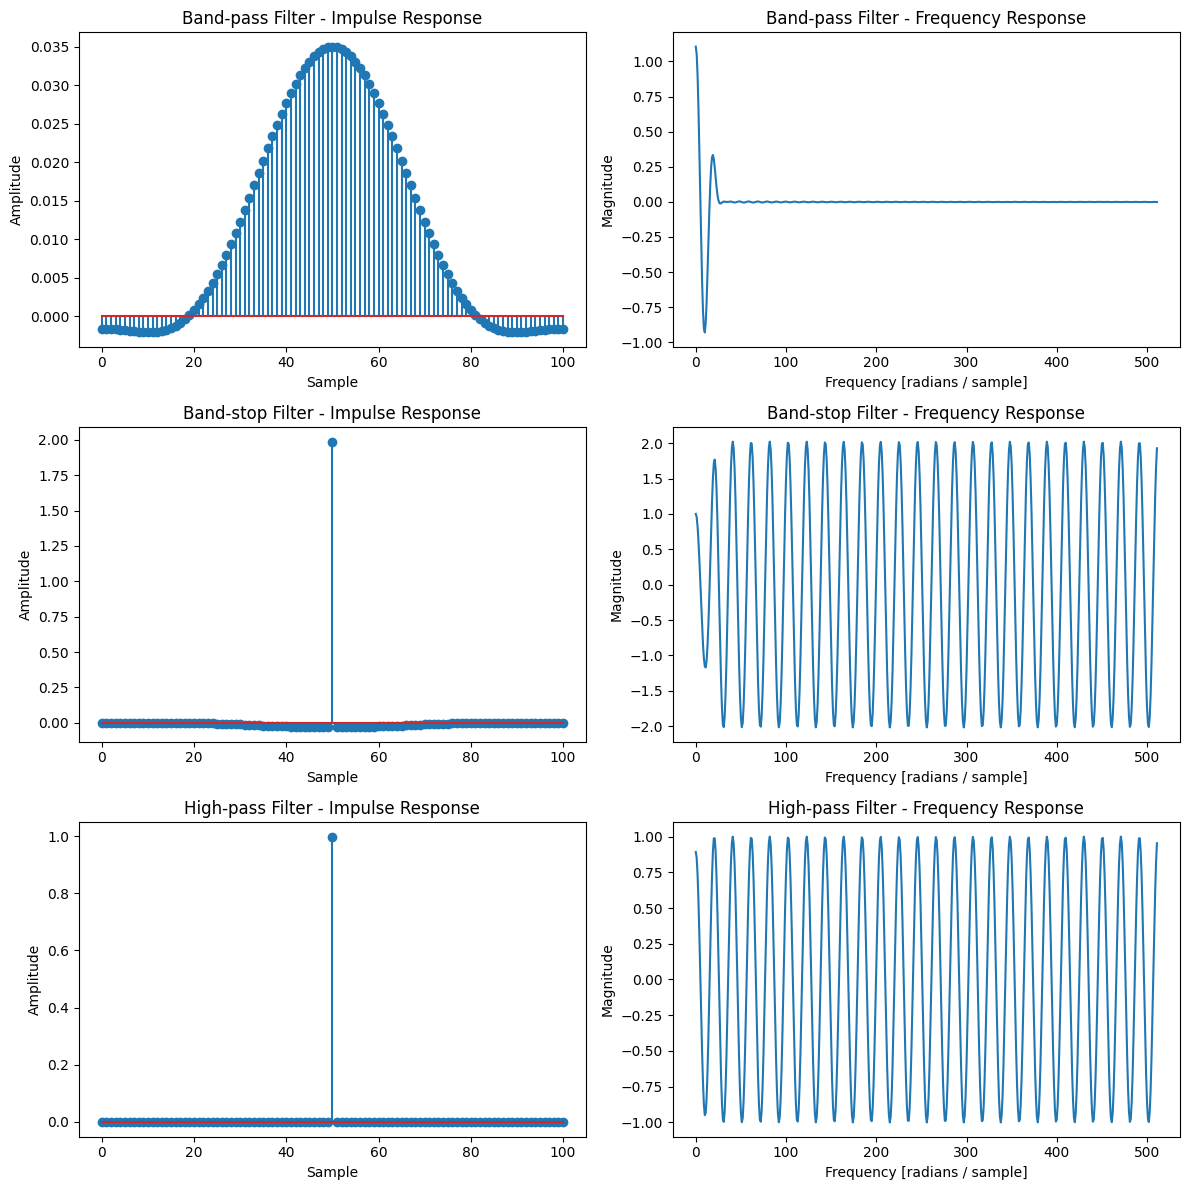

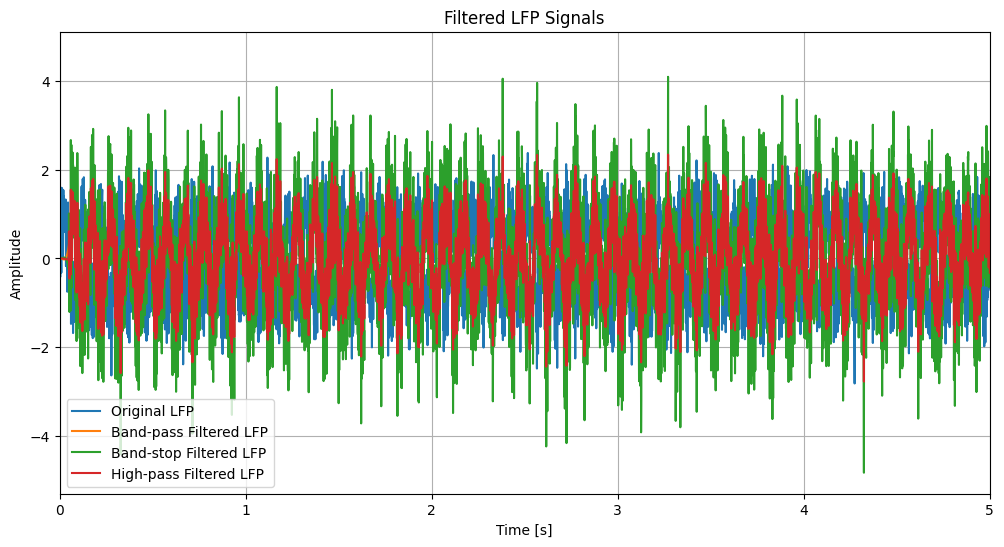

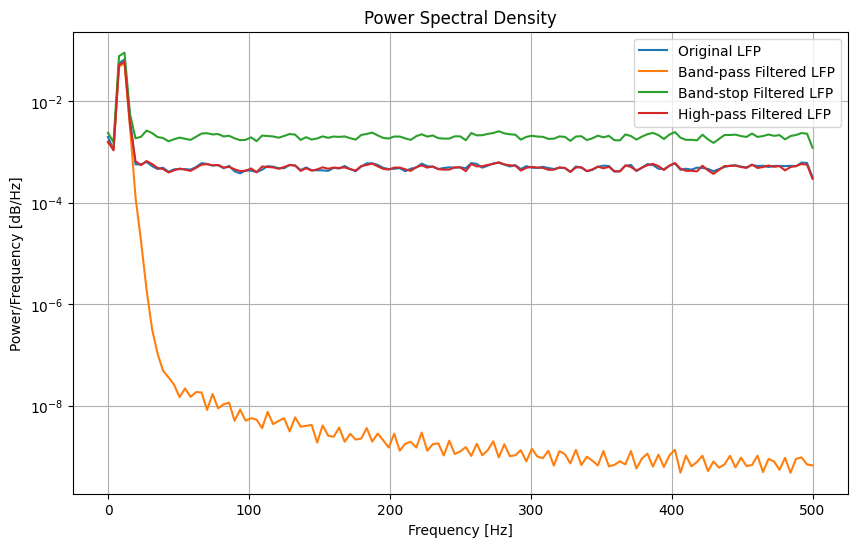

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


fs = 1000
t = np.arange(0, 10, 1/fs)
lfp = np.sin(2 * np.pi * 10 * t) + np.random.normal(scale=0.5, size=len(t))


pass_band = [4, 12]
stop_band = [4, 12]
high_pass = 1


num_taps = 101


b_band_pass = signal.firwin(num_taps, pass_band, fs=fs, pass_zero=False)
b_band_stop = signal.firwin(num_taps, stop_band, fs=fs, pass_zero=True)
b_high_pass = signal.firwin(num_taps, high_pass, fs=fs, pass_zero=False)


fig, axes = plt.subplots(3, 2, figsize=(12, 12))

for i, (b, title) in enumerate(zip([b_band_pass, b_band_stop, b_high_pass],
                                    ['Band-pass Filter', 'Band-stop Filter', 'High-pass Filter'])):
    _, irf = signal.freqz(b)
    axes[i, 0].stem(b)
    axes[i, 0].set_title(f'{title} - Impulse Response')
    axes[i, 0].set_xlabel('Sample')
    axes[i, 0].set_ylabel('Amplitude')

    axes[i, 1].plot(irf)
    axes[i, 1].set_title(f'{title} - Frequency Response')
    axes[i, 1].set_xlabel('Frequency [radians / sample]')
    axes[i, 1].set_ylabel('Magnitude')

plt.tight_layout()
plt.show()
#niby skopiowac 1 komorke wyzej i zedytowac czestotliwosci

lfp_band_pass = signal.lfilter(b_band_pass, 1, lfp)
lfp_band_stop = signal.lfilter(b_band_stop, 1, lfp)
lfp_high_pass = signal.lfilter(b_high_pass, 1, lfp)


plt.figure(figsize=(12, 6))
plt.plot(t, lfp, label='Original LFP')
plt.plot(t, lfp_band_pass, label='Band-pass Filtered LFP')
plt.plot(t, lfp_band_stop, label='Band-stop Filtered LFP')
plt.plot(t, lfp_high_pass, label='High-pass Filtered LFP')
plt.xlim(0, 5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Filtered LFP Signals')
plt.legend()
plt.grid(True)
plt.show()


freqs, psd_original = signal.welch(lfp, fs=fs)
_, psd_band_pass = signal.welch(lfp_band_pass, fs=fs)
_, psd_band_stop = signal.welch(lfp_band_stop, fs=fs)
_, psd_high_pass = signal.welch(lfp_high_pass, fs=fs)

plt.figure(figsize=(10, 6))
plt.semilogy(freqs, psd_original, label='Original LFP')
plt.semilogy(freqs, psd_band_pass, label='Band-pass Filtered LFP')
plt.semilogy(freqs, psd_band_stop, label='Band-stop Filtered LFP')
plt.semilogy(freqs, psd_high_pass, label='High-pass Filtered LFP')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.title('Power Spectral Density')
plt.legend()
plt.grid(True)
plt.show()



**Response (for Task 1, point 4):** Najlepszy filtr jest to band, ponieważ przepuścił nam informacje wyłącznie nam potrzebne z lfp a szumy wytłumił.Z kolei High-pass przepuścił nam wszystko co skutkuje przepuszczeniem nawet szumów,a band-stop pominął najważniejsze informacje.
